In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
from functools import reduce
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, log_loss
from scipy.stats import ks_2samp

In [2]:
acctDF = pd.read_parquet('../../data/q2-ucsd-acctDF.pqt')
acctDF['balance_date'] = pd.to_datetime(acctDF['balance_date'])

consDF_all = pd.read_parquet('../../data/q2-ucsd-consDF.pqt')

consDF = consDF_all.dropna()
trxnDF = pd.read_parquet('../../data/q2-ucsd-trxnDF.pqt')
trxnDF['posted_date'] = pd.to_datetime(trxnDF['posted_date'])

cat_map = pd.read_csv('../../data/q2-ucsd-cat-map.csv')
cat_dict = cat_map.set_index('category_id')['category'].to_dict()

In [3]:
check_acct_totals = acctDF[acctDF.account_type == 'CHECKING'].groupby(['prism_consumer_id', 'balance_date']).sum()
check_acct_totals = check_acct_totals.reset_index()
check_acct_totals = check_acct_totals.drop(axis=1,labels='prism_account_id')
check_acct_totals.head()

,prism_consumer_id,balance_date,account_type,balance
0,0,2021-08-31,CHECKING,294.6700
1,1,2021-06-30,CHECKING,91.2400
2,10,2022-01-31,CHECKING,822.7500
3,100,2021-04-30,CHECKING,802.4000
4,1000,2023-01-31,CHECKING,95.2300


In [4]:
def calc_balances_all(check_acct_totals, trxnDF):
    # Merge transactions with account balances
    merged = trxnDF.merge(
        check_acct_totals[['prism_consumer_id', 'balance_date', 'balance']], 
        on='prism_consumer_id', how='left'
    )

    # Identify pre and post transactions
    merged['is_pre'] = merged['posted_date'] <= merged['balance_date']

    # Set adjustment values based on pre/post period
    merged['adjustment'] = 0.0
    merged.loc[merged['is_pre'] & (merged['credit_or_debit'] == 'CREDIT'), 'adjustment'] = -merged['amount']
    merged.loc[merged['is_pre'] & (merged['credit_or_debit'] == 'DEBIT'), 'adjustment'] = merged['amount']
    merged.loc[~merged['is_pre'] & (merged['credit_or_debit'] == 'CREDIT'), 'adjustment'] = merged['amount']
    merged.loc[~merged['is_pre'] & (merged['credit_or_debit'] == 'DEBIT'), 'adjustment'] = -merged['amount']

    # Pre-balance transactions: Sort descending and apply reverse cumsum
    pre_trans = merged[merged['is_pre']].sort_values(by=['prism_consumer_id', 'posted_date'], ascending=[True, False])
    pre_trans['curr_balance'] = pre_trans.groupby('prism_consumer_id')['adjustment'].cumsum() + pre_trans.groupby('prism_consumer_id')['balance'].transform('first')

    # Post-balance transactions: Sort ascending and apply forward cumsum
    post_trans = merged[~merged['is_pre']].sort_values(by=['prism_consumer_id', 'posted_date'], ascending=[True, True])
    post_trans['curr_balance'] = post_trans.groupby('prism_consumer_id')['adjustment'].cumsum() + post_trans.groupby('prism_consumer_id')['balance'].transform('first')

    # Combine results
    result = pd.concat([pre_trans, post_trans]).sort_values(by=['prism_consumer_id', 'posted_date'])

    return result[['prism_consumer_id', 'prism_transaction_id', 'category', 'amount', 'credit_or_debit', 'posted_date', 'curr_balance']].sort_values(by='posted_date', ascending=False)



In [5]:
balanceDF = calc_balances_all(check_acct_totals, trxnDF)
balanceDF['category'] = balanceDF.category.apply(lambda x: cat_dict[x])

In [6]:
# cat_dict = cat_map.set_index('category_id')['category'].to_dict()
# balanceDF['cat_name'] = balanceDF.category.apply(lambda x: cat_dict[x])

balanceDF.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,curr_balance
2518565,8144,2486689,PAYCHECK,95.1300,CREDIT,2024-05-06,-66.3800
2518585,8144,2486709,AUTOMOTIVE,4.0400,DEBIT,2024-05-06,87.6600
2518578,8144,2486702,EXTERNAL_TRANSFER,150.0000,DEBIT,2024-05-06,83.6200
2518582,8144,2486706,AUTOMOTIVE,12.3200,DEBIT,2024-05-03,117.7600
2518568,8144,2486692,ATM_CASH,83.0000,DEBIT,2024-05-03,105.4400


### Feature Gen

In [7]:
cat_mappings = dict(zip(cat_map['category_id'], cat_map['category']))
trxcat_mappings = dict(zip(cat_map['category_id'], cat_map['category']))
trxnDF['category_id'] = trxnDF.category
trxnDF.category = trxnDF.category.replace(cat_mappings)

In [8]:
def filter_time_window(df, days=None, months=None, years=None):
    def filter_group(group):
        latest_date = group['posted_date'].max()  # Get latest transaction date per consumer
        cutoff_date = latest_date - pd.DateOffset(days=days or 0, months=months or 0, years=years or 0)
        return group[group['posted_date'] >= cutoff_date]  # Filter transactions

    return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)

In [9]:
def compute_balance_delta(balance_filtered, label):
    # Get last balance per consumer
    last_balance = balance_filtered.groupby('prism_consumer_id')['curr_balance'].last().reset_index()
    last_balance = last_balance.rename(columns={'curr_balance': 'curr_balance_last'})
    
    # Get earliest balance in the filtered dataset
    first_balance = balance_filtered.groupby('prism_consumer_id')['curr_balance'].first().reset_index()
    first_balance = first_balance.rename(columns={'curr_balance': 'curr_balance_first'})
    
    # Merge and compute balance delta
    df_merged = last_balance.merge(first_balance, on='prism_consumer_id', how='left')
    df_merged[f'balance_delta_{label}'] = df_merged['curr_balance_last'] - df_merged['curr_balance_first']
    
    # Keep only relevant columns
    return df_merged[['prism_consumer_id', f'balance_delta_{label}']]


In [10]:
def generate_category_features(trxnDF, cat_map, categories):
    """
    Generates transaction-based features for each selected category over multiple time windows.
    
    Parameters:
        trxnDF (pd.DataFrame): DataFrame containing transaction data.
        cat_map (pd.DataFrame): DataFrame mapping category IDs to category names.
        categories (str or list): One or more transaction categories to filter.

    Returns:
        pd.DataFrame: Aggregated features per prism_consumer_id.
    """
    if isinstance(categories, str):
        categories = [categories]

    # trxnDF = trxnDF.merge(cat_map, left_on='category', right_on='category_id', how='left')
    # trxnDF['category'] = trxnDF['category_y']
    # trxnDF = trxnDF.drop(columns=['category_id', 'category_y'])

    trxnDF['posted_date'] = pd.to_datetime(trxnDF['posted_date'])

    time_windows = {
        'overall': None,
        'last_14_days': 14,
        'last_30_days': 30,
        'last_3_months': 90,
        'last_6_months': 180,
        'last_year': 365
    }

    features_dict = {}

    for category in categories:
        # filter transactions for the current category
        filtered_trxn = trxnDF[trxnDF['category'] == category].copy()

        # get last posted date per consumer
        last_posted_dates = filtered_trxn.groupby('prism_consumer_id')['posted_date'].max()

        for window_name, days in time_windows.items():
            if days is None:
                df_time_filtered = filtered_trxn
            else:
                # consumer-specific time filters
                df_time_filtered = filtered_trxn.merge(last_posted_dates, on='prism_consumer_id', suffixes=('', '_latest'))
                df_time_filtered = df_time_filtered[df_time_filtered['posted_date'] >= (df_time_filtered['posted_date_latest'] - pd.Timedelta(days=days))]
                df_time_filtered = df_time_filtered.drop(columns=['posted_date_latest'])

            # aggregate features
            agg_features = df_time_filtered.groupby('prism_consumer_id')['amount'].agg(
                mean='mean',
                median='median',
                std='std',
                max='max',
                min='min',
                count='count'
            )

            # total transaction count per consumer in the time window
            total_trxn_counts = trxnDF.groupby('prism_consumer_id')['amount'].count()

            # compute percentage of transactions in this category for the time window
            percentage_trxn = (agg_features['count'] / total_trxn_counts).fillna(0)
            percentage_trxn = percentage_trxn.rename(f"{category}_{window_name}_percent")

            agg_features = agg_features.rename(columns=lambda x: f"{category}_{window_name}_{x}")

            features_dict[f"{category}_{window_name}"] = pd.concat([agg_features, percentage_trxn], axis=1)


    final_features = pd.concat(features_dict.values(), axis=1).fillna(0)
    return final_features


In [11]:
def compute_threshold_stats(df, thresholds, cat_label):
    # Count total gambling transactions
    counts = df.groupby('prism_consumer_id').size().reset_index(name=f'{cat_label}_count')

    # Check thresholds
    threshold_flags = df.groupby('prism_consumer_id')['amount'].agg(lambda x: [any(x >= t) for t in thresholds]).apply(pd.Series)
    threshold_flags.columns = [f'{cat_label}_over_{t}' for t in thresholds]
    threshold_flags = threshold_flags.astype(bool)  # Convert to True/False

    # Merge counts and flags
    result = counts.merge(threshold_flags, on='prism_consumer_id', how='left')

    return result


In [12]:
# creating relevant outflows df with only expenses
debits_not_expenses = ['SELF_TRANSFER', 'ATM_CASH']
outflows_agg_df = trxnDF[~trxnDF['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_agg_df.columns = ['outflows_amt_' + col for col in outflows_agg_df.columns]

In [13]:
%%time

balance_ftrs = balanceDF.groupby('prism_consumer_id')['curr_balance'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_ftrs.columns = ['balance_' + x for x in balance_ftrs.columns]
balance_last_14_days = filter_time_window(balanceDF, days=14)
balance_last_30_days = filter_time_window(balanceDF, days=30)
balance_last_3_months = filter_time_window(balanceDF, months=1)
balance_last_6_months = filter_time_window(balanceDF, months=6)
balance_last_year = filter_time_window(balanceDF, years=1)

balance_last_14_days_metrics = balance_last_14_days.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_last_14_days_metrics.columns = ['balance_last_14_days_' + x for x in balance_last_14_days_metrics.columns]

balance_last_30_days_metrics = balance_last_30_days.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_last_30_days_metrics.columns = ['balance_last_30_days_' + x for x in balance_last_30_days_metrics.columns]

balance_last_3_months_metrics = balance_last_3_months.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_last_3_months_metrics.columns = ['balance_last_3_months_' + x for x in balance_last_3_months_metrics.columns]

balance_last_6_months_metrics = balance_last_6_months.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_last_6_months_metrics.columns = ['balance_last_6_months_' + x for x in balance_last_6_months_metrics.columns]

balance_last_year_metrics = balance_last_year.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_last_year_metrics.columns = ['balance_last_1_year_' + x for x in balance_last_year_metrics.columns]

balance_dfs = [consDF[['prism_consumer_id']], balance_ftrs, balance_last_14_days_metrics, balance_last_30_days_metrics, balance_last_3_months_metrics, balance_last_6_months_metrics, balance_last_year_metrics]
balance_ftrs = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id', how='left'), balance_dfs)

balance_ftrs.shape

/tmp/ipykernel_242/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_242/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_242/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on t

CPU times: user 1min 8s, sys: 2.41 s, total: 1min 11s
Wall time: 1min 11s


(12000, 31)

In [14]:
%%time

# balance_deltas
balance_delta_overall = compute_balance_delta(balanceDF, 'overall')
balance_delta_14d = compute_balance_delta(balance_last_14_days, '14d')
balance_delta_30d = compute_balance_delta(balance_last_30_days, '30d')
balance_delta_3m = compute_balance_delta(balance_last_3_months, '3m')
balance_delta_6m = compute_balance_delta(balance_last_6_months, '6m')
balance_delta_1y = compute_balance_delta(balance_last_year, '1y')


balance_deltas_dfs = [consDF[['prism_consumer_id']], balance_delta_overall, balance_delta_14d, balance_delta_30d, balance_delta_3m, balance_delta_6m, balance_delta_1y]
balance_deltas_ftrs = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id', how='left'), balance_deltas_dfs)



CPU times: user 2.46 s, sys: 252 ms, total: 2.71 s
Wall time: 2.71 s


In [15]:
%%time

# creating filtered window transactions dfs
trxn_df_last_14_days = filter_time_window(trxnDF, days=14)
trxn_df_last_30_days = filter_time_window(trxnDF, days=30)
trxn_df_last_3_months = filter_time_window(trxnDF, months=3)
trxn_df_last_6_months = filter_time_window(trxnDF, months=6)
trxn_df_last_year = filter_time_window(trxnDF, years=1)

# creating windowed expenses aggregate metrics
outflows_ftrs = trxnDF[~trxnDF['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_ftrs.columns = ['outflows_amt_' + col for col in outflows_ftrs.columns]

outflows_last_14_days_agg_df = trxn_df_last_14_days[~trxn_df_last_14_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_14_days_agg_df.columns = ['outflows_amt_last_14_days_' + col for col in outflows_last_14_days_agg_df.columns]

outflows_last_30_days_agg_df = trxn_df_last_30_days[~trxn_df_last_30_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_30_days_agg_df.columns = ['outflows_amt_last_30_days_' + col for col in outflows_last_30_days_agg_df.columns]

outflows_last_3_months_agg_df = trxn_df_last_3_months[~trxn_df_last_3_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_3_months_agg_df.columns = ['outflows_amt_last_3_months_' + col for col in outflows_last_3_months_agg_df.columns]

outflows_last_6_months_agg_df = trxn_df_last_6_months[~trxn_df_last_6_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_6_months_agg_df.columns = ['outflows_amt_last_6_months_' + col for col in outflows_last_6_months_agg_df.columns]

outflows_last_year_agg_df = trxn_df_last_year[~trxn_df_last_year['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_year_agg_df.columns = ['outflows_amt_last_year_' + col for col in outflows_last_year_agg_df.columns]

outflows_df = [consDF[['prism_consumer_id']], outflows_ftrs, outflows_last_14_days_agg_df, outflows_last_30_days_agg_df, outflows_last_3_months_agg_df, outflows_last_6_months_agg_df, outflows_last_year_agg_df]
outflows_ftrs = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id', how='left'), outflows_df)

outflows_ftrs.shape

/tmp/ipykernel_242/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_242/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_242/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on t

CPU times: user 1min 2s, sys: 2.19 s, total: 1min 4s
Wall time: 1min 4s


(12000, 31)

In [16]:
cat_map.category.unique()

cat_ok = ['SELF_TRANSFER', 'EXTERNAL_TRANSFER', 'DEPOSIT', 'PAYCHECK',
       'MISCELLANEOUS', 'PAYCHECK_PLACEHOLDER', 'REFUND',
       'INVESTMENT_INCOME', 'OTHER_BENEFITS', 
       'SMALL_DOLLAR_ADVANCE', 'TAX', 'LOAN', 'INSURANCE',
       'FOOD_AND_BEVERAGES', 'UNCATEGORIZED', 'GENERAL_MERCHANDISE',
       'AUTOMOTIVE', 'GROCERIES', 'ATM_CASH', 'ENTERTAINMENT', 'TRAVEL',
       'ESSENTIAL_SERVICES', 'ACCOUNT_FEES', 'HOME_IMPROVEMENT',
       'OVERDRAFT', 'CREDIT_CARD_PAYMENT', 'HEALTHCARE_MEDICAL', 'PETS',
       'EDUCATION', 'GIFTS_DONATIONS', 'BILLS_UTILITIES', 'MORTGAGE',
       'RENT', 'BNPL', 'AUTO_LOAN',
       'BANKING_CATCH_ALL', 'DEBT', 'FITNESS', 'TRANSPORATION', 'LEGAL',
       'GOVERNMENT_SERVICES', 'RISK_CATCH_ALL', 'RTO_LTO', 'INVESTMENT',
       'GAMBLING', 'CORPORATE_PAYMENTS', 'TIME_OR_STUFF', 'PENSION']

In [17]:
%%time

category_features = generate_category_features(trxnDF, cat_map, cat_ok)
category_features.shape

CPU times: user 1min 53s, sys: 14.3 s, total: 2min 8s
Wall time: 2min 8s


(14492, 2016)

In [18]:
balanceDF[balanceDF['category'] == 'GAMBLING']

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,curr_balance
2029427,5497,1997551,GAMBLING,25.0000,DEBIT,2023-12-08,"-1,307.5600"
1867752,7107,1835876,GAMBLING,2.5000,DEBIT,2023-12-07,419.4800
1867751,7107,1835875,GAMBLING,"1,006.9900",DEBIT,2023-12-07,416.9800
1845260,7794,1813384,GAMBLING,100.0000,DEBIT,2023-12-05,"2,565.4200"
1845263,7794,1813387,GAMBLING,50.0000,DEBIT,2023-12-05,"2,664.6300"
...,...,...,...,...,...,...,...
462597,1303,454525,GAMBLING,104.0000,DEBIT,2020-07-31,542.2600
462590,1303,454518,GAMBLING,124.0000,DEBIT,2020-07-23,-304.5700
462589,1303,454517,GAMBLING,0.0000,DEBIT,2020-07-23,-428.5700
462579,1303,454507,GAMBLING,0.0000,DEBIT,2020-07-17,308.0400


In [19]:
balanceDF.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,curr_balance
2518565,8144,2486689,PAYCHECK,95.1300,CREDIT,2024-05-06,-66.3800
2518585,8144,2486709,AUTOMOTIVE,4.0400,DEBIT,2024-05-06,87.6600
2518578,8144,2486702,EXTERNAL_TRANSFER,150.0000,DEBIT,2024-05-06,83.6200
2518582,8144,2486706,AUTOMOTIVE,12.3200,DEBIT,2024-05-03,117.7600
2518568,8144,2486692,ATM_CASH,83.0000,DEBIT,2024-05-03,105.4400


In [20]:
%%time

gambling_df_all = balanceDF[balanceDF['category'] == 'GAMBLING']
gambling_thresholds = [50, 100, 500, 1000]

# Filter for different time periods
gambling_last_month = filter_time_window(gambling_df_all, months=1)
gambling_last_6m = filter_time_window(gambling_df_all, months=6)
gambling_last_year = filter_time_window(gambling_df_all, years=1)

gambling_stats_all = compute_threshold_stats(gambling_df_all, gambling_thresholds, 'all')
gambling_stats_month = compute_threshold_stats(gambling_last_month, gambling_thresholds, '1m')
gambling_stats_6m = compute_threshold_stats(gambling_last_6m, gambling_thresholds, '6m')
gambling_stats_year = compute_threshold_stats(gambling_last_year, gambling_thresholds, '1y')

gambling_df = [consDF[['prism_consumer_id']], gambling_stats_all, gambling_stats_month, gambling_stats_6m, gambling_stats_year]
gambling_ftrs = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id', how='left'), gambling_df)

gambling_ftrs.shape

/tmp/ipykernel_242/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_242/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_242/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on t

CPU times: user 5.69 s, sys: 40.6 ms, total: 5.73 s
Wall time: 5.72 s


(12000, 21)

In [21]:
feature_dfs = [consDF[['prism_consumer_id', 'DQ_TARGET']], balance_ftrs, balance_deltas_ftrs, category_features, outflows_ftrs, outflows_agg_df, gambling_ftrs,]
features_all = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id', how='left'), feature_dfs)

features_all.shape

(12000, 2109)

## Model Training

In [22]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier # pip install
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier # pip install

import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
data = features_all.copy().drop(labels='prism_consumer_id', axis=1)

binary_cols = [col for col in data.columns if data[col].nunique() == 2 and sorted(data[col].unique()) == [0, 1]]
continuous_cols = [col for col in data.columns if col not in binary_cols]

scaler = StandardScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])

print(data.shape)
data.head()

(12000, 2108)


,DQ_TARGET,balance_mean,balance_std,balance_median,balance_min,balance_max,balance_last_14_days_mean,balance_last_14_days_std,balance_last_14_days_median,balance_last_14_days_min,...,6m_count,6m_over_50,6m_over_100,6m_over_500,6m_over_1000,1y_count,1y_over_50,1y_over_100,1y_over_500,1y_over_1000
0,0.0000,-0.0821,-0.1851,-0.0753,0.1041,-0.1756,-0.0433,-0.0580,-0.0287,-0.0177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0000,-0.2061,-0.1605,-0.1811,-0.0450,-0.2446,-0.0370,-0.0539,-0.0237,-0.0179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0000,-0.0611,-0.0365,-0.1118,0.0431,-0.1147,-0.0368,-0.0268,-0.0277,-0.0179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0000,-0.2172,-0.0867,-0.1896,-0.2591,-0.2036,-0.0393,-0.0492,-0.0279,-0.0169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0000,-0.0580,-0.2159,-0.0418,0.1095,-0.1887,-0.0394,-0.0589,-0.0281,-0.0180,...,-0.2292,0.8072,1.0195,-0.4276,-0.2676,-0.2275,0.8072,1.0179,-0.4289,-0.2676


In [24]:
### WILL NEED BETTER FIX THAN THIS ###

data.fillna(0, inplace=True)

In [25]:
def fit_model(X_train, y_train, model_type='log_reg'):
    """
    Fits a machine learning model based on the specified type.
    """

    ###############################
    ## MODEL TRAIN BY MODEL TYPE ##
    ###############################
    start = time.time()
    if model_type == 'log_reg':
        model = LogisticRegression(max_iter=1000, n_jobs=-1).fit(X_train, y_train) # TODO: hyperparameter config

    finish = time.time()
    training_time = finish-start
    print(f'Training Time = {training_time:.4f} seconds')
    return model

def predict(X, y, model, le=None):
    """
    Makes predictions using the trained model and evaluates accuracy.
    """
    preds = model.predict(X)
    try: 
        preds_proba = model.predict_proba(X)
        return preds, preds_proba[:, 1]
    except:
        return preds

def evaluate_model(y, y_pred, y_pred_proba):
    # train metrics
    roc_auc = roc_auc_score(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)
    
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    return {'Accuracy': accuracy, 'ROC_AUC': roc_auc}

def pipeline(X, y, model_type='log_reg'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    model = fit_model(X_train, y_train, model_type)
    y_train_pred, y_train_prob = predict(X_train, y_train, model)
    y_test_pred, y_test_prob = predict(X_test, y_test, model)

    print("##### TRAIN METRICS #####")
    train_metrics = evaluate_model(y_train, y_train_pred, y_train_prob)
    print("##### TEST METRICS #####")
    test_metrics = evaluate_model(y_test, y_test_pred, y_test_prob)
    
    return  train_metrics, test_metrics

In [26]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model_type):
    """Trains and evaluates the specified model."""
    models = {
        "HistGB": HistGradientBoostingClassifier(),
        "CatBoost": CatBoostClassifier(verbose=0),
        "LightGBM": LGBMClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "LogisticRegression": LogisticRegression()
    }
    
    if model_type not in models:
        raise ValueError(f"Unsupported model type: {model_type}. Choose from {list(models.keys())}")
    
    model = models[model_type]

    # Train model and track training time
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    
    print(f"Training Time: {end - start:.4f} seconds")

    # Predictions
    start_pred = time.time()
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    end_pred = time.time()

    print(f"Prediction Time: {end_pred - start_pred:.4f} seconds")


    # Evaluation Metrics
    metrics = {
        "ROC_AUC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

    # Print Metrics
    print(f'{model_type} metrics:')
    for metric, value in metrics.items():
        print(f"\t{metric}: {value}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({model_type})")
    plt.show()

    return model, metrics


In [27]:
X = data.drop(columns=["DQ_TARGET"])
y = data['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,)

In [28]:
data.shape

(12000, 2108)

In [29]:
consDF.prism_consumer_id.nunique()

12000

#### SMOTE Data

In [30]:
# !pip install imbalanced-learn

In [31]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter
import pandas as pd

In [32]:
from sklearn.metrics import roc_curve, auc

In [33]:
orig_count = Counter(y_train)
print("Original class distribution:", orig_count, 
      "Percent DQ:", f"{100 * orig_count[1.0] / (orig_count[1.0] + orig_count[0.0]):.2f}%")

Original class distribution: Counter({0.0: 8252, 1.0: 748}) Percent DQ: 8.31%


In [34]:
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
# data_smote = pd.DataFrame(X_resampled, columns=X.columns)
# data_smote['target_column'] = y_resampled

# Check class counts
count_0, count_1 = y_train.value_counts()[0], y_train.value_counts()[1]
new_0 = int(0.8 * count_0)  # Target count for balancing
new_1 = int(2.5* count_1)

# Ensure SMOTE does not create more than the original number of samples
smote = SMOTE(sampling_strategy={1: new_1},)

# Undersampling the majority class to match the new minority class count
under = RandomUnderSampler(sampling_strategy={0: new_0},)

# Combine SMOTE & Undersampling in a pipeline
resample_pipeline = Pipeline(steps=[('smote', smote), ('under', under)])

# Apply resampling
X_resampled, y_resampled = resample_pipeline.fit_resample(X_train, y_train)

In [35]:
end_count = Counter(y_resampled)
print("Original class distribution:", end_count, 
      "Percent DQ:", f"{100 * end_count[1.0] / (end_count[1.0] + end_count[0.0]):.2f}%")

Original class distribution: Counter({0.0: 6601, 1.0: 1870}) Percent DQ: 22.08%


In [36]:
X_train, X_validation, y_train, y_validation = train_test_split(X_resampled, y_resampled, test_size=0.25,)

In [37]:
lr = fit_model(X_train, y_train, 'log_reg')
y_train_pred, y_train_prob = predict(X_train, y_train, lr)
y_validation_pred, y_validation_prob = predict(X_validation, y_validation, lr)
y_test_pred, y_test_prob = predict(X_test, y_test, lr)

Training Time = 8.6169 seconds


In [38]:
lr_train_metrics = evaluate_model(y_train, y_train_pred, y_train_prob)

ROC AUC Score: 0.8996
Accuracy: 0.8705

Confusion Matrix:
[[4737  230]
 [ 593  793]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      4967
         1.0       0.78      0.57      0.66      1386

    accuracy                           0.87      6353
   macro avg       0.83      0.76      0.79      6353
weighted avg       0.86      0.87      0.86      6353



In [39]:
lr_validation_metrics = evaluate_model(y_validation, y_validation_pred, y_validation_prob)

ROC AUC Score: 0.7848
Accuracy: 0.7781

Confusion Matrix:
[[1418  216]
 [ 254  230]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      1634
         1.0       0.52      0.48      0.49       484

    accuracy                           0.78      2118
   macro avg       0.68      0.67      0.68      2118
weighted avg       0.77      0.78      0.77      2118



In [40]:
lr_test_metrics = evaluate_model(y_test, y_test_pred, y_test_prob)

ROC AUC Score: 0.6686
Accuracy: 0.8143

Confusion Matrix:
[[2373  369]
 [ 188   70]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.87      0.89      2742
         1.0       0.16      0.27      0.20       258

    accuracy                           0.81      3000
   macro avg       0.54      0.57      0.55      3000
weighted avg       0.86      0.81      0.84      3000



### Feature Selection (L1 Lasso)

In [41]:
from sklearn.feature_selection import SelectFromModel, RFE

In [42]:
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1) # can test different Cs
model_l1.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [43]:
selector = SelectFromModel(model_l1, prefit=True, threshold=-np.inf, max_features=50)
top_50 = list(X_train.columns[selector.get_support()])
selector = SelectFromModel(model_l1, prefit=True, threshold=-np.inf, max_features=100)
top_100 = list(X_train.columns[selector.get_support()])
selector = SelectFromModel(model_l1, prefit=True, threshold=-np.inf, max_features=200)
top_200 = list(X_train.columns[selector.get_support()])
X_50_train = X_train[top_50]
X_50_validation = X_validation[top_50]
X_50_test = X_test[top_50]
X_100_train = X_train[top_100]
X_100_validation = X_validation[top_100]
X_100_test = X_test[top_100]
X_200_train = X_train[top_200]
X_200_validation = X_validation[top_200]
X_200_test = X_test[top_200]

Training Time: 0.0309 seconds
Prediction Time: 0.0049 seconds
LogisticRegression metrics:
	ROC_AUC: 0.7477119728496717
	Accuracy: 0.7813975448536356
	Precision: 0.5532994923857868
	Recall: 0.22520661157024793
	F1-Score: 0.3201174743024963
	Confusion Matrix: [[1546   88]
 [ 375  109]]


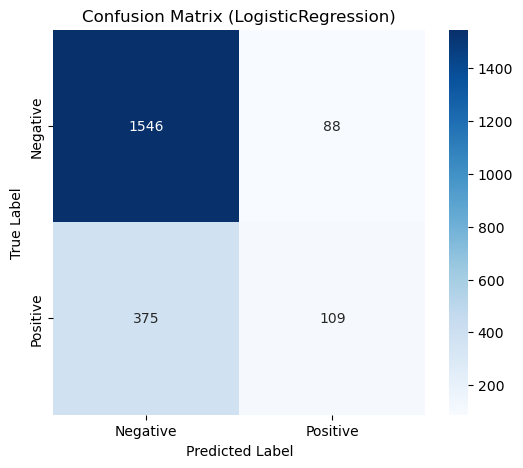

In [44]:
model, results = train_and_evaluate(X_50_train, y_train, X_50_validation, y_validation, model_type="LogisticRegression")

Training Time: 0.0271 seconds
Prediction Time: 0.0046 seconds
LogisticRegression metrics:
	ROC_AUC: 0.7165595191649845
	Accuracy: 0.8813333333333333
	Precision: 0.25980392156862747
	Recall: 0.2054263565891473
	F1-Score: 0.22943722943722944
	Confusion Matrix: [[2591  151]
 [ 205   53]]


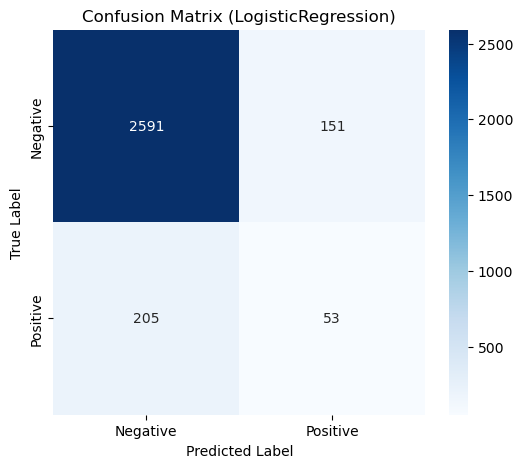

In [45]:
model, results = train_and_evaluate(X_50_train, y_train, X_50_test, y_test, model_type="LogisticRegression")

Training Time: 0.1394 seconds
Prediction Time: 0.0119 seconds
LogisticRegression metrics:
	ROC_AUC: 0.7768949088076716
	Accuracy: 0.7870632672332389
	Precision: 0.5673469387755102
	Recall: 0.2871900826446281
	F1-Score: 0.3813443072702332
	Confusion Matrix: [[1528  106]
 [ 345  139]]


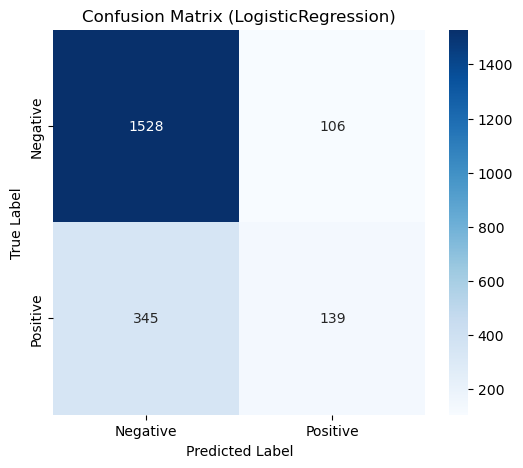

In [46]:
model, results = train_and_evaluate(X_100_train, y_train, X_100_validation, y_validation, model_type="LogisticRegression")

Training Time: 0.1523 seconds
Prediction Time: 0.0126 seconds
LogisticRegression metrics:
	ROC_AUC: 0.7121025788905287
	Accuracy: 0.8766666666666667
	Precision: 0.2647058823529412
	Recall: 0.2441860465116279
	F1-Score: 0.2540322580645161
	Confusion Matrix: [[2567  175]
 [ 195   63]]


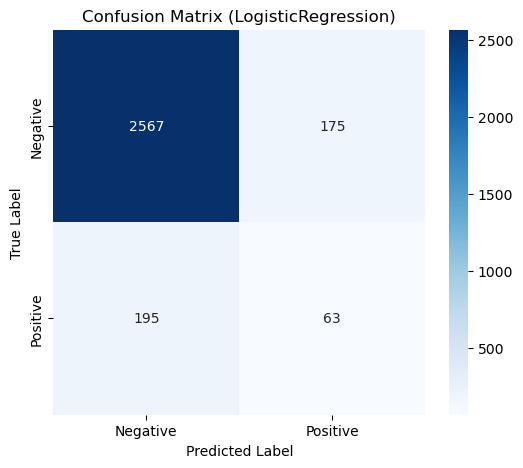

In [47]:
model, results = train_and_evaluate(X_100_train, y_train, X_100_test, y_test, model_type="LogisticRegression")

Training Time: 0.2600 seconds
Prediction Time: 0.1013 seconds
LogisticRegression metrics:
	ROC_AUC: 0.7823927491224699
	Accuracy: 0.7903682719546742
	Precision: 0.5666666666666667
	Recall: 0.3512396694214876
	F1-Score: 0.4336734693877551
	Confusion Matrix: [[1504  130]
 [ 314  170]]


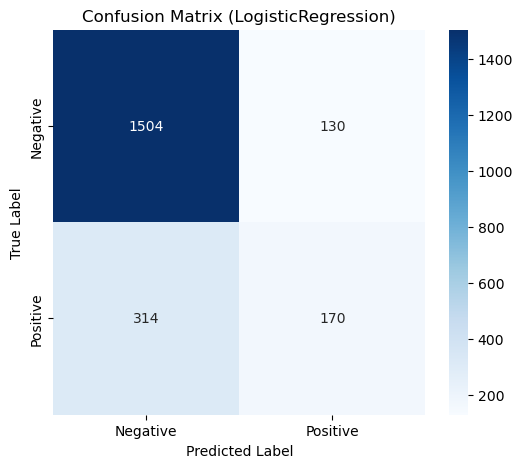

In [48]:
model, results = train_and_evaluate(X_200_train, y_train, X_200_validation, y_validation, model_type="LogisticRegression")

Training Time: 0.2500 seconds
Prediction Time: 0.1028 seconds
LogisticRegression metrics:
	ROC_AUC: 0.711298265850197
	Accuracy: 0.8586666666666667
	Precision: 0.2014388489208633
	Recall: 0.21705426356589147
	F1-Score: 0.208955223880597
	Confusion Matrix: [[2520  222]
 [ 202   56]]


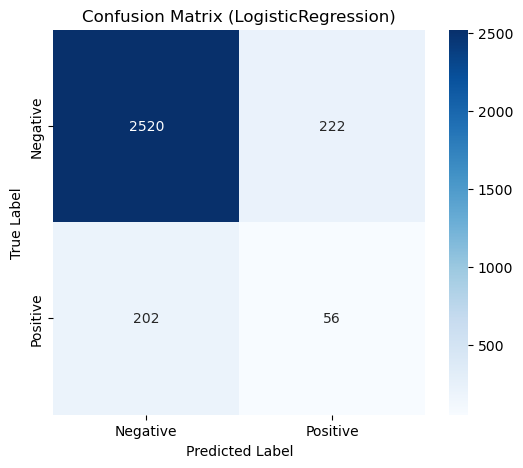

In [49]:
model, results = train_and_evaluate(X_200_train, y_train, X_200_test, y_test, model_type="LogisticRegression")

Training Time: 0.6873 seconds
Prediction Time: 0.0184 seconds
HistGB metrics:
	ROC_AUC: 0.9068863358184043
	Accuracy: 0.8899905571293674
	Precision: 0.9087947882736156
	Recall: 0.5764462809917356
	F1-Score: 0.7054361567635904
	Confusion Matrix: [[1606   28]
 [ 205  279]]


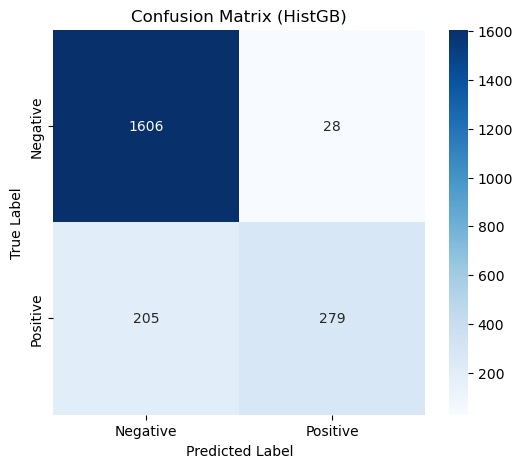

In [50]:
model, results = train_and_evaluate(X_100_train, y_train, X_100_validation, y_validation, model_type="HistGB")

Training Time: 0.6491 seconds
Prediction Time: 0.0189 seconds
HistGB metrics:
	ROC_AUC: 0.7383296863603208
	Accuracy: 0.9066666666666666
	Precision: 0.3472222222222222
	Recall: 0.09689922480620156
	F1-Score: 0.15151515151515152
	Confusion Matrix: [[2695   47]
 [ 233   25]]


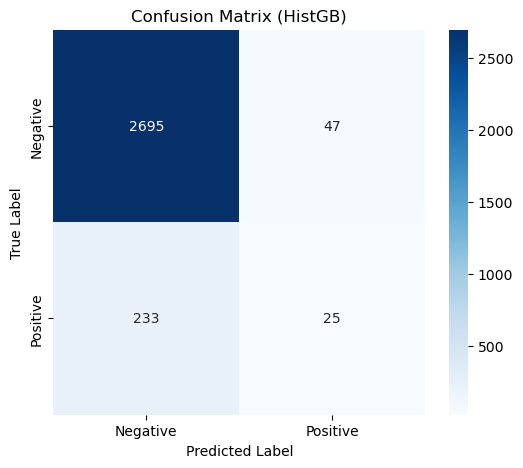

In [51]:
model, results = train_and_evaluate(X_100_train, y_train, X_100_test, y_test, model_type="HistGB")

Training Time: 0.9799 seconds
Prediction Time: 0.0255 seconds
HistGB metrics:
	ROC_AUC: 0.9102061563672781
	Accuracy: 0.8951841359773371
	Precision: 0.9119496855345912
	Recall: 0.5991735537190083
	F1-Score: 0.7231920199501247
	Confusion Matrix: [[1606   28]
 [ 194  290]]


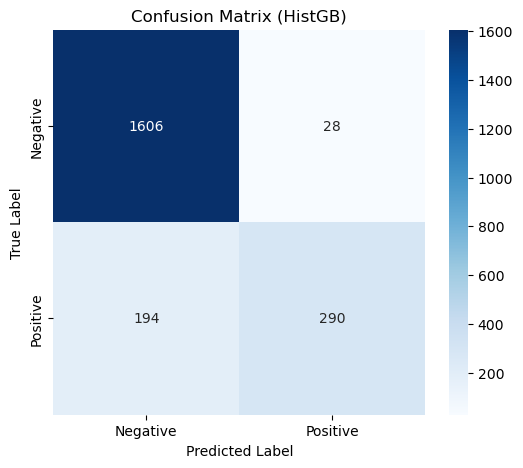

In [52]:
model, results = train_and_evaluate(X_200_train, y_train, X_200_validation, y_validation, model_type="HistGB")

Training Time: 1.0031 seconds
Prediction Time: 0.0253 seconds
HistGB metrics:
	ROC_AUC: 0.7537982234435341
	Accuracy: 0.9113333333333333
	Precision: 0.4411764705882353
	Recall: 0.11627906976744186
	F1-Score: 0.18404907975460122
	Confusion Matrix: [[2704   38]
 [ 228   30]]


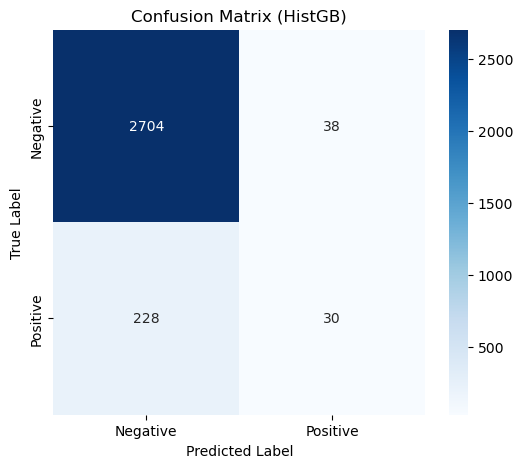

In [53]:
model, results = train_and_evaluate(X_200_train, y_train, X_200_test, y_test, model_type="HistGB")

[LightGBM] [Info] Number of positive: 1386, number of negative: 4967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24177
[LightGBM] [Info] Number of data points in the train set: 6353, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218165 -> initscore=-1.276394
[LightGBM] [Info] Start training from score -1.276394
Training Time: 0.4120 seconds
Prediction Time: 0.0119 seconds
LightGBM metrics:
	ROC_AUC: 0.9088576175688114
	Accuracy: 0.8923512747875354
	Precision: 0.9129032258064517
	Recall: 0.5847107438016529
	F1-Score: 0.7128463476070529
	Confusion Matrix: [[1607   27]
 [ 201  283]]


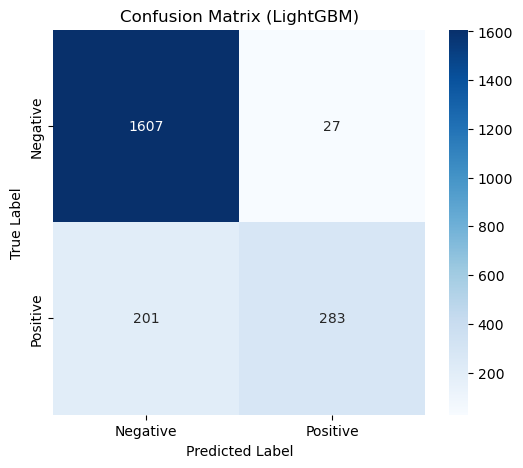

In [54]:
model, results = train_and_evaluate(X_100_train, y_train, X_100_validation, y_validation, model_type="LightGBM")

[LightGBM] [Info] Number of positive: 1386, number of negative: 4967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24177
[LightGBM] [Info] Number of data points in the train set: 6353, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218165 -> initscore=-1.276394
[LightGBM] [Info] Start training from score -1.276394
Training Time: 0.3958 seconds
Prediction Time: 0.0152 seconds
LightGBM metrics:
	ROC_AUC: 0.7302257730734654
	Accuracy: 0.9096666666666666
	Precision: 0.3968253968253968
	Recall: 0.09689922480620156
	F1-Score: 0.1557632398753894
	Confusion Matrix: [[2704   38]
 [ 233   25]]


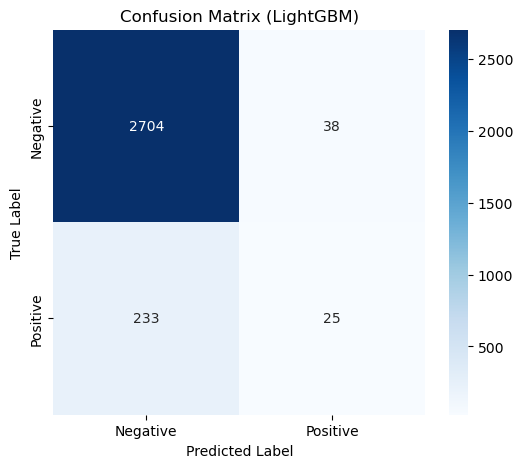

In [55]:
model, results = train_and_evaluate(X_100_train, y_train, X_100_test, y_test, model_type="LightGBM")

[LightGBM] [Info] Number of positive: 1386, number of negative: 4967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48188
[LightGBM] [Info] Number of data points in the train set: 6353, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218165 -> initscore=-1.276394
[LightGBM] [Info] Start training from score -1.276394
Training Time: 0.6857 seconds
Prediction Time: 0.0187 seconds
LightGBM metrics:
	ROC_AUC: 0.9125264270613108
	Accuracy: 0.8975448536355052
	Precision: 0.9320388349514563
	Recall: 0.5950413223140496
	F1-Score: 0.7263556116015133
	Confusion Matrix: [[1613   21]
 [ 196  288]]


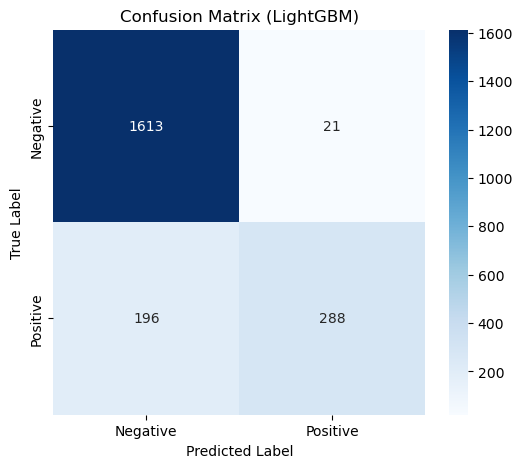

In [56]:
model, results = train_and_evaluate(X_200_train, y_train, X_200_validation, y_validation, model_type="LightGBM")

[LightGBM] [Info] Number of positive: 1386, number of negative: 4967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48188
[LightGBM] [Info] Number of data points in the train set: 6353, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218165 -> initscore=-1.276394
[LightGBM] [Info] Start training from score -1.276394
Training Time: 0.9213 seconds
Prediction Time: 0.0213 seconds
LightGBM metrics:
	ROC_AUC: 0.74884512521274
	Accuracy: 0.9093333333333333
	Precision: 0.3939393939393939
	Recall: 0.10077519379844961
	F1-Score: 0.16049382716049382
	Confusion Matrix: [[2702   40]
 [ 232   26]]


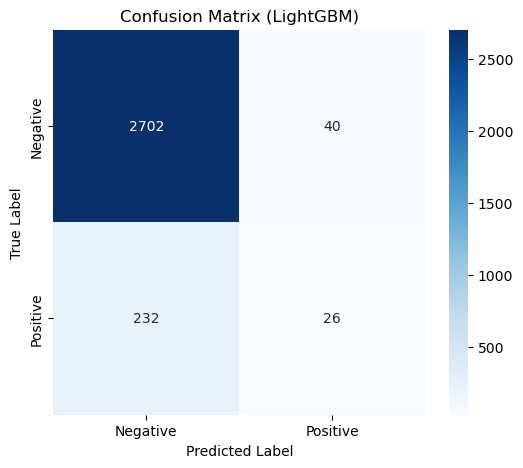

In [57]:
model, results = train_and_evaluate(X_200_train, y_train, X_200_test, y_test, model_type="LightGBM")

Training Time: 0.5188 seconds
Prediction Time: 0.0142 seconds
HistGB metrics:
	ROC_AUC: 0.9016692040017399
	Accuracy: 0.8890462700661
	Precision: 0.878419452887538
	Recall: 0.5971074380165289
	F1-Score: 0.7109471094710947
	Confusion Matrix: [[1594   40]
 [ 195  289]]


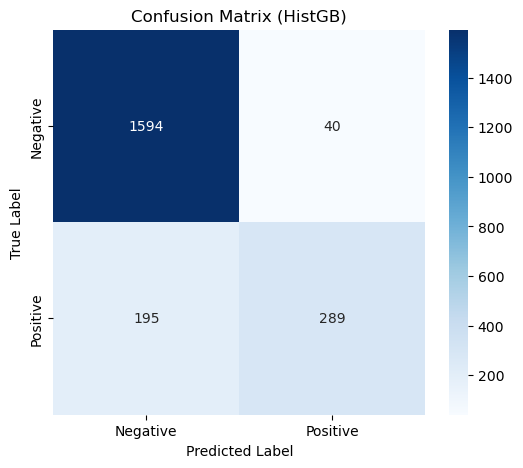

In [58]:
model, results = train_and_evaluate(X_50_train, y_train, X_50_validation, y_validation, model_type="HistGB")

Training Time: 0.5161 seconds
Prediction Time: 0.0196 seconds
HistGB metrics:
	ROC_AUC: 0.7246634324518402
	Accuracy: 0.9026666666666666
	Precision: 0.27631578947368424
	Recall: 0.08139534883720931
	F1-Score: 0.12574850299401197
	Confusion Matrix: [[2687   55]
 [ 237   21]]


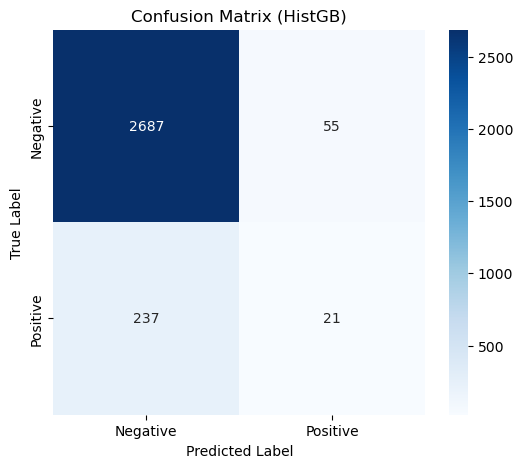

In [59]:
model, results = train_and_evaluate(X_50_train, y_train, X_50_test, y_test, model_type="HistGB")

##### HistGB Output #####
Training Time: 8.2015 seconds
Prediction Time: 0.1478 seconds
HistGB metrics:
	ROC_AUC: 0.7519719098264719
	Accuracy: 0.9093333333333333
	Precision: 0.375
	Recall: 0.08139534883720931
	F1-Score: 0.1337579617834395
	Confusion Matrix: [[2707   35]
 [ 237   21]]


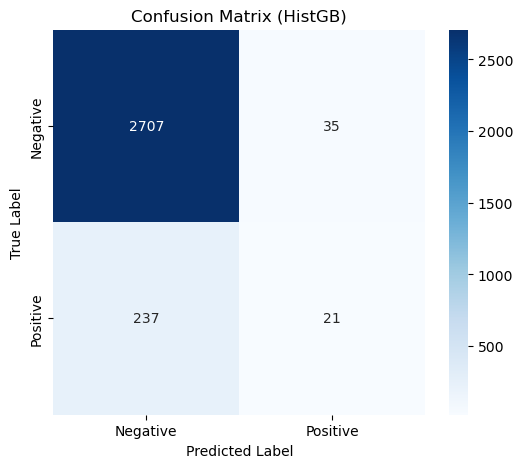

##### CatBoost Output #####


In [ ]:
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
eval_data = {}
roc_data = {}

for model_type in model_types:
    print(f'##### {model_type} Output #####')
    model, results = train_and_evaluate(X_train, y_train, X_test, y_test, model_type)
    del results['Confusion Matrix']
    eval_data[model_type] = results
    
    # Get ROC Curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test) if hasattr(model, "decision_function") else model.predict(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    roc_data[model_type] = (fpr, tpr, roc_auc)

eval_data = pd.DataFrame(eval_data)

# Plot all ROC curves at once
plt.figure(figsize=(10, 7))
for model_type, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{model_type} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Different Models')
plt.legend()
plt.grid()
plt.show()

### Feature Selection (Embedded Method)

In [ ]:
rf = RandomForestClassifier()
# rf.fit(X_train, y_train)

rf = RandomForestClassifier(
    n_estimators=300,        # More trees for stability (100-500 is a good range)
    max_depth=15,            # Limit depth to avoid overfitting (None allows full growth)
    min_samples_split=5,      # Require at least 5 samples to split a node (prevents overfitting)
    min_samples_leaf=2,       # Minimum of 2 samples per leaf for better generalization
    max_features='sqrt',      # Use sqrt(features) at each split (good balance of performance)
    bootstrap=True,           # Bootstrap sampling (default, helps with variance reduction)
    random_state=42,          # For reproducibility
    n_jobs=-1                 # Use all CPU cores for faster training
)

rf.fit(X_resampled, y_resampled)

In [ ]:
feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
importance_df['Importance_Abs'] = importance_df.Importance.apply(lambda x: abs(x))


# Sort by importance (descending order)
importance_df = importance_df.sort_values(by="Importance_Abs", ascending=False)
importance_df.head(10)

In [ ]:
top_100_ftrs = importance_df.Feature.values[:100]

X_100 = X_train[top_100_ftrs]
X_100_test = X_test[top_100_ftrs]

X_100.shape, y_train.shape

In [ ]:
X_100_train, X_100_validation, y_100_train, y_100_validation = train_test_split(X_100, y_train, test_size=0.25,)

In [ ]:
lr_100_train_metrics, lr_100_test_metrics = pipeline(X_100, y_train)

### More Models

Training Time: 8.6668 seconds
Prediction Time: 0.1608 seconds
HistGB metrics:
	ROC_AUC: 0.7420727811420397
	Accuracy: 0.9083333333333333
	Precision: 0.36065573770491804
	Recall: 0.08527131782945736
	F1-Score: 0.13793103448275862
	Confusion Matrix: [[2703   39]
 [ 236   22]]


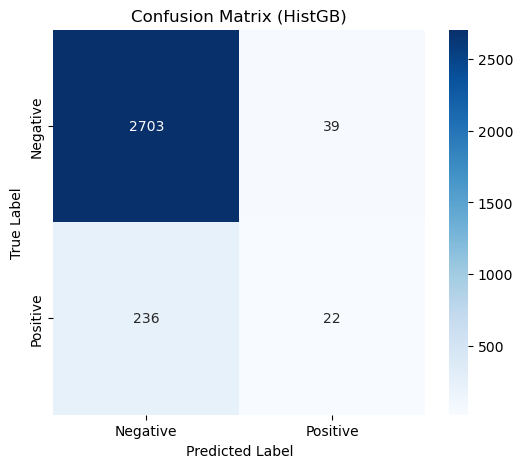

In [372]:
model, results = train_and_evaluate(X_resampled, y_resampled, X_test, y_test, model_type="HistGB")

Training Time: 0.5888 seconds
Prediction Time: 0.0194 seconds
HistGB metrics:
	ROC_AUC: 0.732802684624475
	Accuracy: 0.9043333333333333
	Precision: 0.32098765432098764
	Recall: 0.10077519379844961
	F1-Score: 0.15339233038348082
	Confusion Matrix: [[2687   55]
 [ 232   26]]


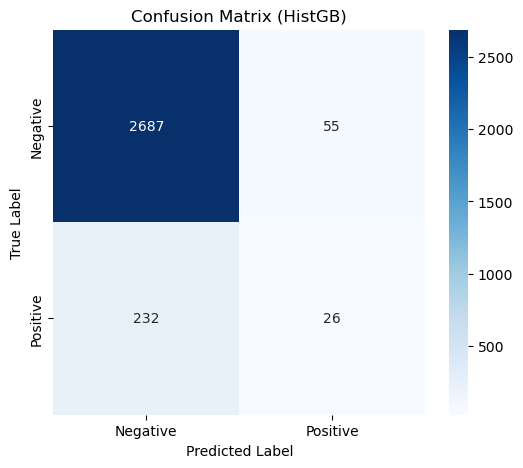

In [373]:
model, results = train_and_evaluate(X_100_train, y_100_train, X_100_test, y_test, model_type="HistGB")

[LightGBM] [Info] Number of positive: 862, number of negative: 3692
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16943
[LightGBM] [Info] Number of data points in the train set: 4554, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.189284 -> initscore=-1.454668
[LightGBM] [Info] Start training from score -1.454668
Training Time: 0.3272 seconds
Prediction Time: 0.0143 seconds
LightGBM metrics:
	ROC_AUC: 0.736575464070248
	Accuracy: 0.905
	Precision: 0.3291139240506329
	Recall: 0.10077519379844961
	F1-Score: 0.1543026706231454
	Confusion Matrix: [[2689   53]
 [ 232   26]]


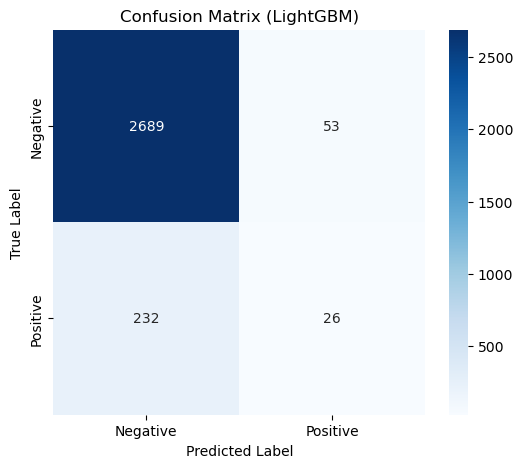

In [374]:
model, results = train_and_evaluate(X_100_train, y_100_train, X_100_test, y_test, model_type="LightGBM")